# Simple RNN

## Pseudocode RNN

In [0]:
# For first timestep, no current state - all 0 vector
state_t = 0 

# For every input (sample) in a sequence of inputs
for input_t in input_sequence:
  # The current output is a function of the current input and current state (which is the previous output)
  output_t = f(input_t, state_t) 

  # The current output becomes the state for the next iteration
  state_t = output_t

The function `f` is a non-linear transformation of the current input `input_t` and the previous output `state_t` using dot products and an activation function. 

It is paramterised by 2 weight matrices - `W` and `U`, and a bias vector `b`.

In [0]:
# For first timestep, no current state - all 0 vector
state_t = 0

# For every timestep in a sequence of timesteps:
for input_t in input_sequence:
  # Current output - activation of linear sum of dot products of input and state
  output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
  
  # State for next step - current output
  state_t = output_t

## Numpy Implementation of Simple RNN

In [0]:
import numpy as np

timesteps = 100             # Number of timsteps in input sequence
input_features = 32         # Dimensionality of input space for RNN layer
output_features = 64        # Dimensionality of output space for RNN layer 

# Input data consists of `input_features`-dimensional vector for each `timestep`
# Random for the sake of the example
inputs = np.random.random((timesteps, input_features))

# Initial state - all zero vector - no state for the first timstep
state_t = np.zeros((output_features, ))

# Transformation matrices 
W = np.random.random((output_features, input_features))   # dot product with input_t
U = np.random.random((output_features, output_features))  # dot product with state_t
b = np.random.random((output_features, ))                 # bias

# Store output at each timestep in a list
successive_outputs = []

# For every timestep in the sequence of timesteps  
for input_t in inputs: 
  # input_t is a vector of shape (input_features, )
  # Combine the input with the current state (previous output) to obtain current output
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)

  # Append this output to the list of successive outputs
  successive_outputs.append(output_t)

  # Update the state of the network for the next timestamp
  state_t = output_t 


# Final output is a 2D tensor of shape (timesteps, output_features)
final_output_sequence = np.concatenate(successive_outputs, axis=0) # Along rows

## RNN in `keras` - Last State Only

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

Using TensorFlow backend.


In [0]:
# Instantiate a model
model = Sequential()

# First layer - Embedding - 10000 dimensional vector condensed to 32 dimensional vector
model.add(Embedding(10000, 32))

# Second layer - Simple RNN - will output a 32-dimensional vector
model.add(SimpleRNN(32))

# Describe the model
model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


## RNN with `keras` - Full State Sequence

Instead of returning the output only at the last timestep, the RNN below will return the outputs at all timesteps between `t_0` and `t_end`.

In [0]:
# Instantiate
model = Sequential()

# First layer is still and Embedding layer
model.add(Embedding(10000, 32))

# Second layer is RNN, but this time with `return_sequences=True`
model.add(SimpleRNN(32, return_sequences=True))

# Dimensionality of layers has changed - output layer returns (batch, samples, 32-dimensional vector)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


## Stacking RNN Layers

Stacking several RNN layers increases the representational power of the network. It requires that all RNN layers return the full sequence of outputs upto and including `t`. Last layer may or may not return the full sequence - not necessary.

In [0]:
# Instantiate 
model = Sequential()

# First layer - Embedding
model.add(Embedding(10000, 32))

# First RNN Layer - must return sequences for next layer to use
model.add(SimpleRNN(32, return_sequences=True))

# Second RNN Layer - must also return sequences for next layer to use 
model.add(SimpleRNN(32, return_sequences=True))

# Third RNN Layer - must return sequences because next layer is RNN
model.add(SimpleRNN(32, return_sequences=True))

# Final RNN Layer - not necessary to return output
model.add(SimpleRNN(32))

# Model summary - output of the final layer is a single 32-dimensional vector representing
# output at the final timestep for each batch 
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


# RNN with IMDB Data

## Data Preprocessing

In [0]:
from keras.datasets import imdb
from keras.preprocessing import sequence

In [0]:
max_features = 10000                # Number of words to consider features 
maxlen = 500                        # Will only consider first 500 words in review for encoding (among max_features most common words)
batch_size = 32                     # RNN will process batches of 32 reviews at a time 

In [0]:
print('Loading data...')

# Will load reviews that are one-hot encoded in terms of the 10k most commonly occurring words
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)

Loading data...
17465344/17464789 [==============================] - 2s 0us/step


In [0]:
# Number of reviews in the training and test sets
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

25000 train sequences
25000 test sequences


In [0]:
# Reviews can be of different lengths, but tensors being processed by NN must
# be of the same dimensions. Zero padding the sequences so that each review 
# is a 500 dimensional vector
print("Pad Sequqences (samples x time)")
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)

Pad Sequqences (samples x time)


In [0]:
# What is the shape of the sequences after padding? 
print('input_train shape:', input_train.shape)
print('input_test.shape:', input_test.shape)

input_train shape: (25000, 500)
input_test.shape: (25000, 500)


## Training - `SimpleRNN` with `Embedding`

In [0]:
from keras.layers import Dense

In [0]:
# Instantiate
model = Sequential()

# First layer - converts sparse 500-dimensional vectors to dense 32-dimensional vectos
model.add(Embedding(max_features, 32))

# Recurrent layer - next layer is not recurrent, so no need to return all output sequences
model.add(SimpleRNN(32))

# Last layer is sigmoid classifier - 0/1 (negative/positive) review
model.add(Dense(1, activation='sigmoid'))

In [0]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)




Train on 20000 samples, validate on 5000 samples
Epoch 1/10





20000/20000 [==============================] - 19s 950us/step - loss: 0.6185 - acc: 0.6409 - val_loss: 0.4500 - val_acc: 0.8080
Epoch 2/10
20000/20000 [==============================] - 18s 916us/step - loss: 0.4440 - acc: 0.8121 - val_loss: 0.3827 - val_acc: 0.8448
Epoch 3/10
20000/20000 [==============================] - 18s 904us/step - loss: 0.3171 - acc: 0.8742 - val_loss: 0.3965 - val_acc: 0.8236
Epoch 4/10
20000/20000 [==============================] - 18s 897us/step - loss: 0.2323 - acc: 0.9118 - val_loss: 0.3277 - val_acc: 0.8790
Epoch 5/10
20000/20000 [==============================] - 18s 899us/step - loss: 0.1765 - acc: 0.9353 - val_loss: 0.4158 - val_acc: 0.8414
Epoch 6/10
20000/20000 [==============================] - 18s 894us/step - loss: 0.1218 - acc: 0.9578 - val_loss: 0.4348 - val_acc: 0.8358
Epoch 7/10
20000/20000 [==============================] - 18s 895us/step - loss: 0.0799 - acc: 0.9741 - val_l

## Plotting Model History

In [0]:
import matplotlib.pyplot as plt 

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

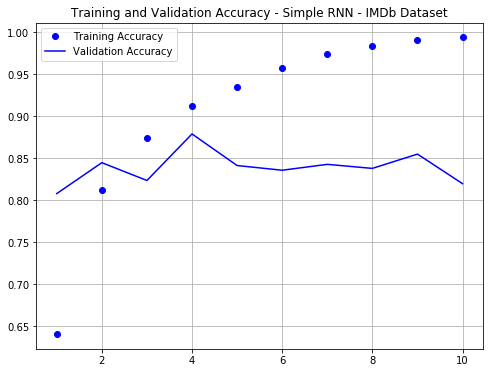

In [0]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy - Simple RNN - IMDb Dataset')
plt.legend()
plt.grid(True)

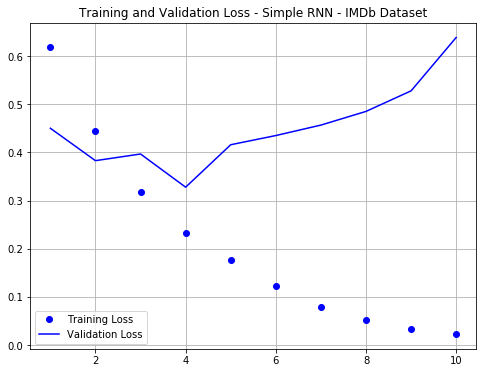

In [0]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss - Simple RNN - IMDb Dataset')
plt.legend()
plt.grid(True)

# `LSTM` with `keras`

Will build an `LSTM`-based sequence model for the `IMDb` dataset. This will improve review classification performance because the `LSTM` allows information from past timesteps to be reinjected into the computation of a future state at a later time, thus preventing the vanishing gradients problem.

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM

In [0]:
# Instantiate a model
model = Sequential()

# First layer is still Embedding 
model.add(Embedding(max_features, 32))

# Second layer - LSTM - need only specify the output dimensionality 
model.add(LSTM(32))

# Final layer - sigmoid activation function - for classification
model.add(Dense(1, activation='sigmoid'))

In [0]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [0]:
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 88s 4ms/step - loss: 0.5682 - acc: 0.7385 - val_loss: 0.4527 - val_acc: 0.8066
Epoch 2/10
20000/20000 [==============================] - 90s 4ms/step - loss: 0.3330 - acc: 0.8691 - val_loss: 0.3036 - val_acc: 0.8754
Epoch 3/10
20000/20000 [==============================] - 90s 5ms/step - loss: 0.2511 - acc: 0.9046 - val_loss: 0.3180 - val_acc: 0.8632
Epoch 4/10
20000/20000 [==============================] - 90s 5ms/step - loss: 0.2129 - acc: 0.9209 - val_loss: 0.2830 - val_acc: 0.8944
Epoch 5/10
20000/20000 [==============================] - 92s 5ms/step - loss: 0.1842 - acc: 0.9325 - val_loss: 0.2982 - val_acc: 0.8852
Epoch 6/10
20000/20000 [==============================] - 92s 5ms/step - loss: 0.1679 - acc: 0.9412 - val_loss: 0.2992 - val_acc: 0.8754
Epoch 7/10
20000/20000 [==============================] - 90s 5ms/step - loss: 0.1489 - acc: 0.9473 - val_loss: 0.3113 - val_acc:

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

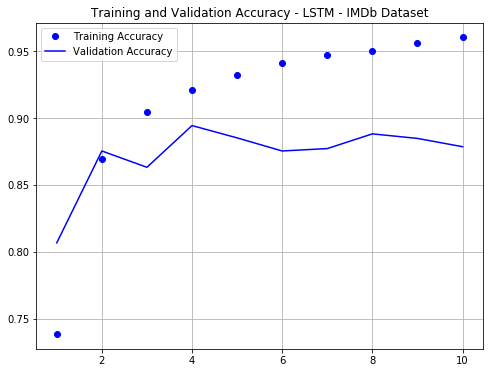

In [0]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy - LSTM - IMDb Dataset')
plt.legend()
plt.grid(True)

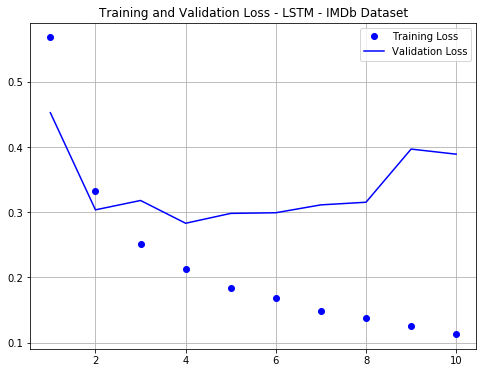

In [0]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss - LSTM - IMDb Dataset')
plt.legend()
plt.grid(True)

# Sequence Model Case Study: Temperature Forecasting

## Downloading Data

All commands prefaced with an exclamation mark `!` are shell commands that are run by the Google CoLab operating system, and not Python commands that are run by the Python server.

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2020-03-03 04:20:05--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.143.70
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.143.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  6.50MB/s    in 2.0s    

2020-03-03 04:20:08 (6.50 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]



In [2]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


## Inspecting Data

In [0]:
import os

In [0]:
data_dir = '.'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [0]:
# Open filestream for reading data
f = open(fname)

# Read the contents into a Python structure (dictionary?)
data = f.read()

# Close filestream when done
f.close()

In [0]:
# `data` is a list of lists: each constituent list is one line
lines = data.split('\n')

# First line - header - contains column names
header = lines[0].split(',')

# All subsequent lines are samples - timesteps and their corresponding features
lines = lines[1:]

In [29]:
# What does the header look like?
for column in header:
  print(column)

"Date Time"
"p (mbar)"
"T (degC)"
"Tpot (K)"
"Tdew (degC)"
"rh (%)"
"VPmax (mbar)"
"VPact (mbar)"
"VPdef (mbar)"
"sh (g/kg)"
"H2OC (mmol/mol)"
"rho (g/m**3)"
"wv (m/s)"
"max. wv (m/s)"
"wd (deg)"


In [0]:
# Converting all lines of data to numpy array
import numpy as np

In [0]:
# Create null array of same dimensions as (input_samples, features)
float_data = np.zeros((len(lines), len(header) - 1))

In [0]:
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

Each line in the `lines` list was another list of comma-separated values. We split each list into individual samples by looking at the `,` as a demarcator, and then convert them to floating point values (it is possible that they have been read as `string`s).

We drop the first value in each list because that is a timestamp, and we aren't concerned with timestamps as a feature.

These values replace the zeros in the `values` numpy array we created before running the for loop.

## Plotting Temperature Data

In [0]:
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'JENA Climate Data - Temperature')

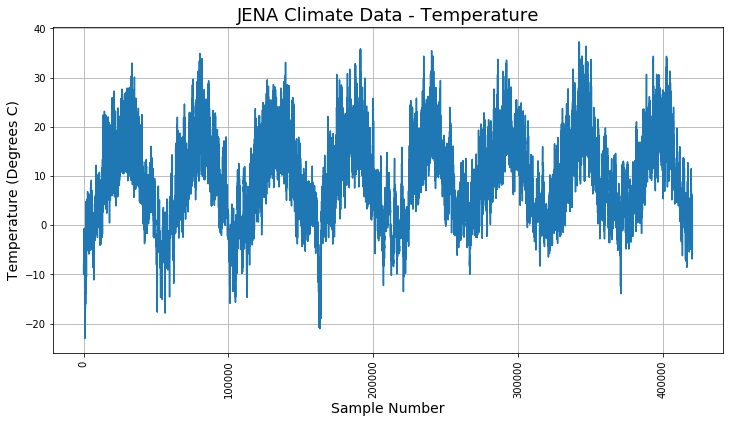

In [34]:
temp = float_data[:, 1] # Temperature in degrees Celsius

plt.figure(figsize=(12, 6))
# X-axis: sample numbers, y-axis: temperature
plt.plot(range(len(temp)), temp)
plt.xlabel('Sample Number', fontsize=14)
plt.xticks(rotation=90)
plt.ylabel('Temperature (Degrees C)', fontsize=14)
plt.grid(True)
plt.title('JENA Climate Data - Temperature', fontsize=18)

In [0]:
MEASUREMENT_PERIOD_MINS = 10
MINS_PER_DAY = 24 * 60 
SAMPLES_PER_DAY = MINS_PER_DAY / MEASUREMENT_PERIOD_MINS
NUM_DAYS = 10
NUM_SAMPLES = NUM_DAYS * SAMPLES_PER_DAY

In [36]:
print(NUM_SAMPLES)

1440.0


Text(0.5, 1.0, 'JENA Climate Data - Temperature\nFirst 10 Days')

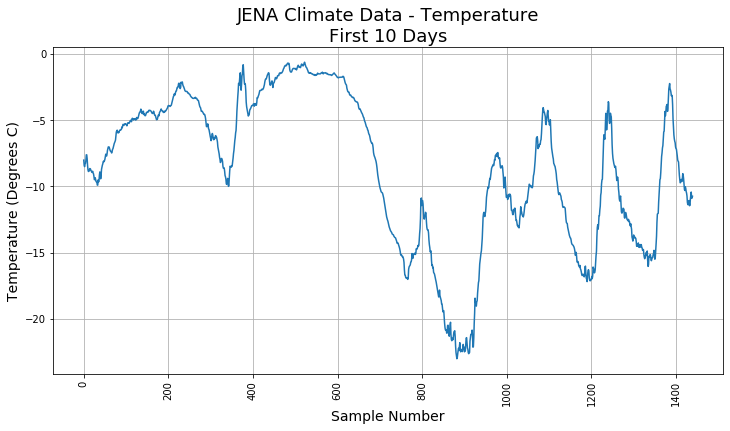

In [37]:
# Plot of the first 10 days - since 144 samples per day, 1440 samples
plt.figure(figsize=(12, 6))
plt.plot(range(int(NUM_SAMPLES)), temp[:int(NUM_SAMPLES)])
plt.xlabel('Sample Number', fontsize=14)
plt.xticks(rotation=90)
plt.ylabel('Temperature (Degrees C)', fontsize=14)
plt.grid(True)
plt.title('JENA Climate Data - Temperature\nFirst 10 Days', fontsize=18)

## Framing the Problem
Given data going as far back as `lookback` timesteps and sampled every `steps` timesteps, can you predict the temperature in `delay` timesteps? 

In our problem, 
- `lookback`: 720 - observations will go back 5 days.
- `steps`: 6 - observations will be sampled at one data point per hour (1 timestep is 10 mins, 60 mins in an hour, so 60/10 = 6 timesteps if sampled once every hour)
- `delay`: 144 - targets will be temperature in 24 hours time.

## Normalizing Data

In [0]:
# Using the first 200,000 timesteps as training data
mean = float_data[:200000].mean(axis=0)
float_data -= mean 
std = float_data[:200000].std(axis=0)
float_data /= std

## Generator 

In simple words, a `generator` is a function which that behaves like an iterator i.e. a function that can be used in place of an iterable data structure such as a list, dictionary, tuple etc. in a for loop.

Our generator will take the current sample and yield batches of data from the recent past as well as the target temperature in the future 'on the fly'. 

Generating these batches on the fly is useful because there is going to be a lot of redundancy in previous samples for samples `N` and `N + 1`. It is inefficient to allocate memory for them every time. So instead, we just generate the sample on the fly. 

### Generator Parameters
- `data`: original data that has been normalized
- `lookback`: how many timesteps back the input data should go
- `delay`: how many timesteps in the future the target should be 
- `min_index` and `max_index`: indices in the `data` array that delimit which timesteps to draw data from. 
- `shuffle`: whether to shuffle the samples or draw them in chronological order.
- `batch_size`: the number of samples per batch.
- `step`: the period, in timesteps, at which you sample data. To draw one sample per hour, this must be set to 6.

### Generator Definition

In [0]:
def generator(data, lookback, delay, min_index, max_index, 
              shuffle=False, batch_size=128, step=6, reverse=False):
  
  # If no max index specified, assume max index from which to draw data
  # is the last index for which a temperature exists `delay` samples later
  if max_index is None:
    max_index = len(data) - delay - 1

  # Start iterating from the first index for which `lookback` previous samples are available
  i = min_index + lookback

  # Is a generator, so should theoretically yield samples endlessly
  while 1:
    # If the user has asked to shuffle samples before drawing
    if shuffle:
      # Get random integers (represented indices) between first index and last index
      rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
    
    # Otherwise, samples are drawn sequentially
    else:
      # Reset current sample index if 128 further samples cannot be drawn from specified range
      if i + batch_size >= max_index:
        i = min_index + lookback

      # Chronological indices from `i` to either the next `batch_size`, or the `max_index` - whichever is smaller
      rows = np.arange(i, min(i + batch_size, max_index))

      # Update the index to the first sample of the next batch
      i += len(rows)
    
    # Make a null array to store the features of sampled timesteps in past data
    samples = np.zeros((len(rows),            # Batch?
                       lookback // step,      # Integer division - samples
                       data.shape[-1]))       # Features

  
    # Make similar null array to store future temperature values for each timestep
    targets = np.zeros((len(rows),))

    # For every index in list of row indices
    for j, row in enumerate(rows):
      # Find the indices for the past samples that will be used to make predictions 
      # Sampled every `step` samples, so must specify this as last argument
      indices = range(rows[j] - lookback, rows[j], step)

      # Extract past samples used for predicting future temperature
      samples[j] = data[indices]

      # Extract future temperature  
      targets[j] = data[rows[j] + delay][1]

    # Return the sample and targets
    if reverse:
      yield samples[:, ::-1, :], targets
    else:
      yield samples, targets

### Generator Values

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128 

# How many steps to draw from the val_gen in order to see entire validation set
val_steps = (300000 - 200001 - lookback) // batch_size

# How many steps to draw from test_gen in order to see entire test set 
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### Train Generators

In [0]:
train_gen = generator(float_data, 
                      lookback=lookback, 
                      delay=delay, 
                      min_index=0, 
                      max_index=200000, 
                      shuffle=True, 
                      step=step, 
                      batch_size=batch_size)

In [0]:
train_gen_reverse = generator(float_data, 
                              lookback=lookback,
                              delay=delay,
                              min_index=0,
                              max_index=200000, 
                              shuffle=True,
                              step=step, 
                              batch_size=batch_size,
                              reverse=True)

### Validation Generator

In [0]:
val_gen = generator(float_data, 
                    lookback=lookback, 
                    delay=delay, 
                    min_index=200001, 
                    max_index=300000, 
                    step=step, 
                    batch_size=batch_size)

### Test Generator

In [0]:
test_gen = generator(float_data,
                     lookback=lookback, 
                     delay=delay, 
                     min_index=300001,
                     max_index=None, 
                     step=step, 
                     batch_size=batch_size)

## Non-ML Baseline

In [0]:
def evaluate_naive_method():
  batch_maes = []

  for step in range(val_steps):
    if (step % 2500 == 0):
      print(".", end="")

    samples, targets = next(val_gen)

    # Tomorrow's predicted temperature = today's temperature
    preds = samples[:, -1, 1]

    # Find MAE for this batch's predictions
    mae = np.mean(np.abs(preds - targets))

    # Append to batch_maes
    batch_maes.append(mae)
  
  # Print the mean MAE of all batches
  print()
  print(np.mean(batch_maes))
  return np.mean(batch_maes)

In [0]:
naive_mae = evaluate_naive_method()

.
0.2897359729905486


In [0]:
# After accounting for standard deviation and scaling
celsius_mae =  naive_mae * std[1]
print(celsius_mae)

2.564887434980494


## Densely Connected Classifier

Can we get good performance from a low complexity AI model? 

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [0]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mae')

In [0]:
history = model.fit_generator(train_gen, 
                              steps_per_epoch=500, 
                              epochs=20, 
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 15s 31ms/step - loss: 0.4890 - val_loss: 0.4019
Epoch 2/20
500/500 [==============================] - 15s 30ms/step - loss: 0.3059 - val_loss: 0.3391
Epoch 3/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2519 - val_loss: 0.3291
Epoch 4/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2235 - val_loss: 0.3294
Epoch 5/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2064 - val_loss: 0.3225
Epoch 6/20
500/500 [==============================] - 15s 31ms/step - loss: 0.1957 - val_loss: 0.3344
Epoch 7/20
500/500 [==============================] - 15s 31ms/step - loss: 0.1913 - val_loss: 0.3416
Epoch 8/20
500/500 [==============================] - 15s 31ms/step - loss: 0.1802 - val_loss: 0.3330
Epoch 9/20
500/500 [==============================] - 15s 31ms/step - loss: 0.1734 - val_loss: 0.3472
Epoch 10/20
500/500 [==============================] - 16s 31ms/step - loss: 0.169

### Validation and Training Loss Curves

In [0]:
import matplotlib.pyplot as plt 

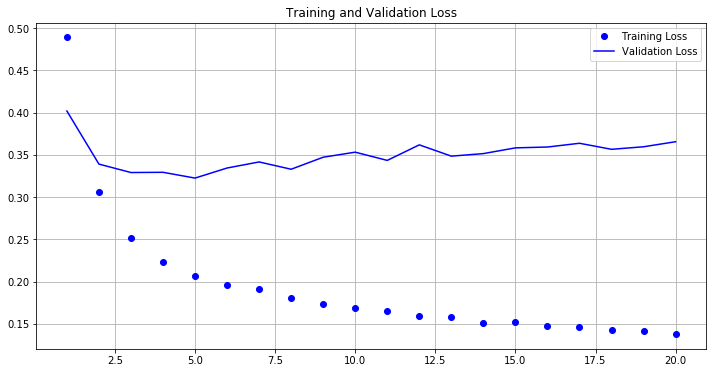

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

## Recurrent Baseline

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [0]:
# Instantiate model
model = Sequential()

# GRU layer - computationally cheaper than LSTM
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

# Compule
model.compile(optimizer='adam', loss='mae')

In [0]:
# Fit to the training data
history = model.fit_generator(train_gen,
                    steps_per_epoch=500,
                    epochs=20, 
                    validation_data=val_gen, 
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 127s 253ms/step - loss: 0.2918 - val_loss: 0.2694
Epoch 2/20
500/500 [==============================] - 124s 249ms/step - loss: 0.2804 - val_loss: 0.2672
Epoch 3/20
500/500 [==============================] - 124s 248ms/step - loss: 0.2719 - val_loss: 0.2644
Epoch 4/20
500/500 [==============================] - 124s 248ms/step - loss: 0.2665 - val_loss: 0.2701
Epoch 5/20
500/500 [==============================] - 123s 245ms/step - loss: 0.2589 - val_loss: 0.2679
Epoch 6/20
500/500 [==============================] - 121s 243ms/step - loss: 0.2539 - val_loss: 0.2696
Epoch 7/20
500/500 [==============================] - 122s 244ms/step - loss: 0.2489 - val_loss: 0.2718
Epoch 8/20
500/500 [==============================] - 124s 248ms/step - loss: 0.2423 - val_loss: 0.2770
Epoch 9/20
500/500 [==============================] - 124s 247ms/step - loss: 0.2380 - val_loss: 0.2810
Epoch 10/20
500/500 [==============================] - 124s 249m

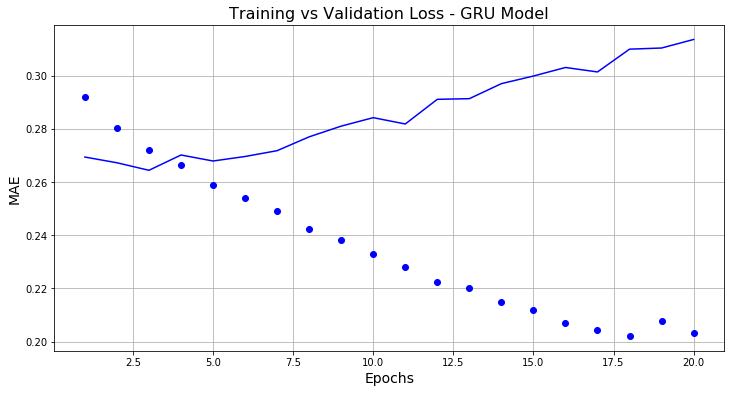

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.title('Training vs Validation Loss - GRU Model', fontsize=16)
plt.grid(True)

In [0]:
optimal_loss = 0.265
print("With RNN, mean absolute error in degrees C is: ", optimal_loss * std[1])

With RNN, mean absolute error in degrees C is:  2.3459122567842243


## Regularization Technique 1 - Dropout and Recurrent Dropout 

- `dropout`: dropout rate for the inputs of the layer (applying dropout before recurrent layer hinders learning).
- `recurrent_dropout`: dropout rate of recurrent units (same mask applied to recurrent activations at all timesteps). 

Networks being regularized with dropout take longer to train and converge, so better to train for more epochs.

In [0]:
from keras.models import Sequential
from keras import layers

In [0]:
model = Sequential()
model.add(layers.GRU(32, 
                     dropout=0.2, 
                     recurrent_dropout=0.2, 
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mae')

In [49]:
history = model.fit_generator(train_gen, 
                              steps_per_epoch=100, 
                              epochs=20, 
                              validation_data=val_gen, 
                              validation_steps=val_steps//5)

Epoch 1/20
100/100 [==============================] - 27s 265ms/step - loss: 0.3873 - val_loss: 0.2757
Epoch 2/20
100/100 [==============================] - 25s 252ms/step - loss: 0.3339 - val_loss: 0.2937
Epoch 3/20
100/100 [==============================] - 25s 253ms/step - loss: 0.3273 - val_loss: 0.2736
Epoch 4/20
100/100 [==============================] - 25s 252ms/step - loss: 0.3224 - val_loss: 0.2941
Epoch 5/20
100/100 [==============================] - 25s 253ms/step - loss: 0.3209 - val_loss: 0.2715
Epoch 6/20
100/100 [==============================] - 25s 253ms/step - loss: 0.3178 - val_loss: 0.2587
Epoch 7/20
100/100 [==============================] - 25s 250ms/step - loss: 0.3124 - val_loss: 0.2783
Epoch 8/20
100/100 [==============================] - 25s 251ms/step - loss: 0.3159 - val_loss: 0.2718
Epoch 9/20
100/100 [==============================] - 25s 246ms/step - loss: 0.3129 - val_loss: 0.2839
Epoch 10/20
100/100 [==============================] - 25s 251ms/step - l

In [0]:
def plot_history(history, plot_metrics=False, title_str=None):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.figure(figsize=(12, 6))
  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
  plt.xlabel('Epochs', fontsize=14)
  plt.ylabel('MAE', fontsize=14)
  title = (title_str + ' - Training and Validation Loss' if title_str is not None
           else 'Training and Validation Loss')
  plt.title(title, fontsize=18)
  plt.grid(True)
  plt.legend()


  if plot_metrics:
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    title = (title_str + ' - Training and Validation Accuracy' if title_str is not None 
             else 'Training and Validation Accuracy')
    plt.title(title)
    plt.grid(True)

  plt.show()

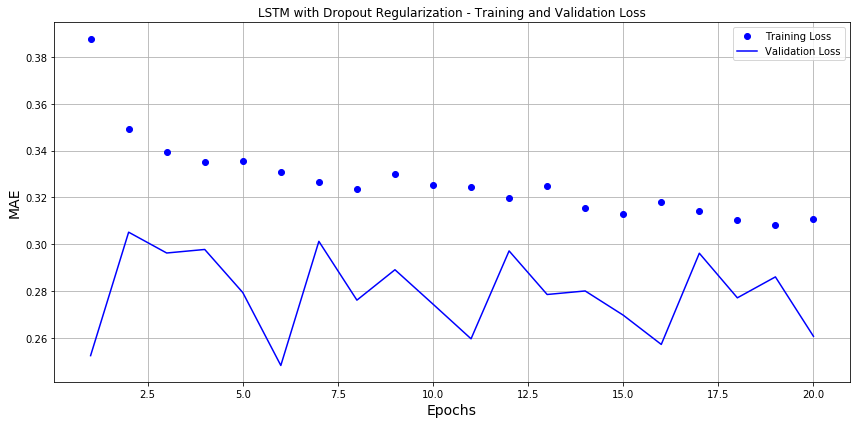

In [62]:
plot_history(history, title_str='LSTM with Dropout Regularization')

## Regularization Technique 2 - Stacking Recurrent Layers

The training history for the regularized model indicates that while we have achieved more stable validation scores and are no longer overfitting at later epochs, the validation scores are not much better than they were before. 

This suggests that the model's performance bottleneck has less to do with overfitting and more to do with lack of learning capacity. 

Increase learning capacity by stacking more recurrent layers.

As with `SimpleRNN` layers, each stacked recurrent layer must return the full sequence of outputs (a 3D tensor) rather than their output at the last timestep.

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [0]:
# Instantiate a model
model = Sequential()

# First recurrent layer - still has dropout, but rates adjusted - must return outputs at all timesteps
model.add(layers.GRU(32, 
                     dropout=0.1,
                     recurrent_dropout=0.5, 
                     return_sequences=True, 
                     input_shape=(None, float_data.shape[-1])))

# Add anotherr recurrent layer - this one has same dropout, but doesn't return all sequences
model.add(layers.GRU(64, 
                     dropout=0.1, 
                     recurrent_dropout=0.5))

# Adding a final linear activation unit
model.add(layers.Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mae')

In [60]:
history = model.fit_generator(train_gen, 
                              steps_per_epoch=50, 
                              epochs=20, 
                              validation_data=val_gen, 
                              validation_steps=val_steps // 5)

Epoch 1/20
50/50 [==============================] - 46s 920ms/step - loss: 0.3878 - val_loss: 0.2524
Epoch 2/20
50/50 [==============================] - 43s 864ms/step - loss: 0.3494 - val_loss: 0.3052
Epoch 3/20
50/50 [==============================] - 43s 867ms/step - loss: 0.3393 - val_loss: 0.2963
Epoch 4/20
50/50 [==============================] - 43s 862ms/step - loss: 0.3352 - val_loss: 0.2978
Epoch 5/20
50/50 [==============================] - 43s 858ms/step - loss: 0.3356 - val_loss: 0.2794
Epoch 6/20
50/50 [==============================] - 43s 855ms/step - loss: 0.3310 - val_loss: 0.2482
Epoch 7/20
50/50 [==============================] - 44s 871ms/step - loss: 0.3264 - val_loss: 0.3012
Epoch 8/20
50/50 [==============================] - 43s 863ms/step - loss: 0.3234 - val_loss: 0.2761
Epoch 9/20
50/50 [==============================] - 43s 860ms/step - loss: 0.3301 - val_loss: 0.2891
Epoch 10/20
50/50 [==============================] - 43s 863ms/step - loss: 0.3251 - val_lo

In [0]:
plot_history(history, title_str='Stacked GRUs (32 - 64) with Dropout')

## Regularization Technique 3 - Antichronological RNNs

- All networks trained so far have processed data in chronological order.
- It is also possible to process sequences in reverse chronological order.
- Will this improve performance?

### Reverse Chronological GRU Baseline - JENA

Will evaluate a GRU trained on reverse chronological order training data. 

This will establish that reversing the order in which sequences are sampled may not work for forecasting problems such as temperature prediction (where the recent past is more indicative of futue predictions than older samples).

Without dropout, the information from the recent past - which is more indicative of temperature in the future - will be lost as RNN moves on to next samples (which, in this case, are samples that were measured much earlier than the day for which prediction has to be made).

In [0]:
from keras.layers import Dense, GRU 
from keras.models import Sequential

In [0]:
# Instantiate
model = Sequential()

# Add layers
model.add(GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

# Compile
model.compile(optimizer='adam', loss='mae')

In [75]:
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=100, 
                              epochs=20, 
                              validation_data=val_gen, 
                              validation_steps=val_steps // 5)

Epoch 1/20
100/100 [==============================] - 25s 246ms/step - loss: 0.5444 - val_loss: 0.3244
Epoch 2/20
100/100 [==============================] - 22s 225ms/step - loss: 0.4803 - val_loss: 0.3428
Epoch 3/20
100/100 [==============================] - 23s 227ms/step - loss: 0.4769 - val_loss: 0.2953
Epoch 4/20
100/100 [==============================] - 23s 226ms/step - loss: 0.4677 - val_loss: 0.3365
Epoch 5/20
100/100 [==============================] - 23s 228ms/step - loss: 0.4686 - val_loss: 0.3459
Epoch 6/20
100/100 [==============================] - 22s 224ms/step - loss: 0.4724 - val_loss: 0.3399
Epoch 7/20
100/100 [==============================] - 23s 227ms/step - loss: 0.4628 - val_loss: 0.3742
Epoch 8/20
100/100 [==============================] - 23s 231ms/step - loss: 0.4620 - val_loss: 0.3208
Epoch 9/20
100/100 [==============================] - 23s 232ms/step - loss: 0.4521 - val_loss: 0.3495
Epoch 10/20
100/100 [==============================] - 23s 228ms/step - l

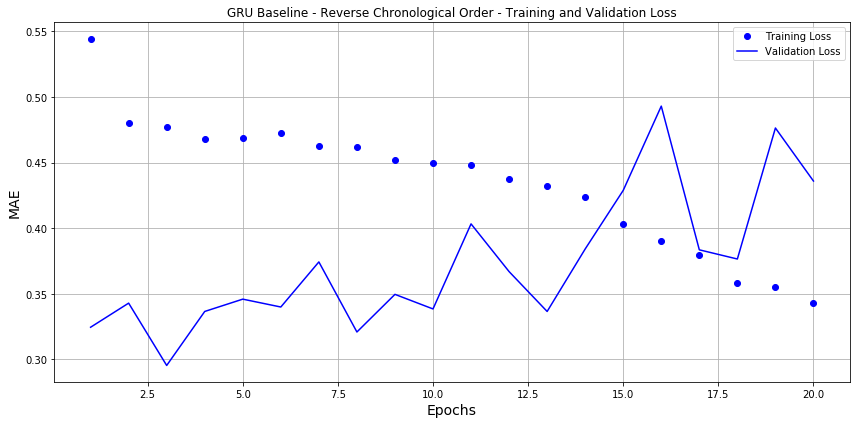

In [76]:
plot_history(history, 'GRU Baseline - Reverse Chronological Order')

As expected, reverse chronological order does not work for problems in which recent samples are more strongly associated with future predictions than earlier samples. 

### Reverse Chronological LSTM - IMDb

However, reverse chronological order can be very useful when processing natural language sequences.

Intuitively, the importance of a word in understanding a sentence isn't usually dependent on its position in the sentence. 

In [0]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers 
from keras.models import Sequential

In [80]:
# Number of words to consider as features - each element of a sample tensor
# will thus be encoded using integers in [0, 10000)
max_features = 10000

# Cuts off texts after this number of words (among the max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

17465344/17464789 [==============================] - 2s 0us/step


In [0]:
# Reverse sequences 
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

In [0]:
# Pad sequences so that they have the same length - 500 words
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

In [0]:
# Instantiate
model = Sequential()

# Add layers
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [90]:
# Train
history = model.fit(x_train, y_train, epochs=10, batch_size=128, 
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 121s 6ms/step - loss: 0.5180 - acc: 0.7308 - val_loss: 0.3571 - val_acc: 0.8636
Epoch 2/10
20000/20000 [==============================] - 121s 6ms/step - loss: 0.2908 - acc: 0.8892 - val_loss: 0.3470 - val_acc: 0.8752
Epoch 3/10
20000/20000 [==============================] - 119s 6ms/step - loss: 0.2143 - acc: 0.9220 - val_loss: 0.3342 - val_acc: 0.8768
Epoch 4/10
20000/20000 [==============================] - 119s 6ms/step - loss: 0.2037 - acc: 0.9234 - val_loss: 0.3634 - val_acc: 0.8620
Epoch 5/10
20000/20000 [==============================] - 120s 6ms/step - loss: 0.1347 - acc: 0.9552 - val_loss: 0.3956 - val_acc: 0.8656
Epoch 6/10
20000/20000 [==============================] - 119s 6ms/step - loss: 0.1102 - acc: 0.9655 - val_loss: 0.4460 - val_acc: 0.8664
Epoch 7/10
20000/20000 [==============================] - 118s 6ms/step - loss: 0.1216 - acc: 0.9597 - val_loss: 0.4625 - v

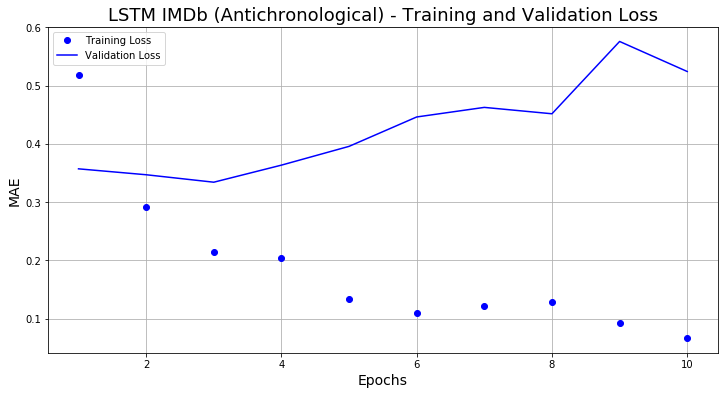

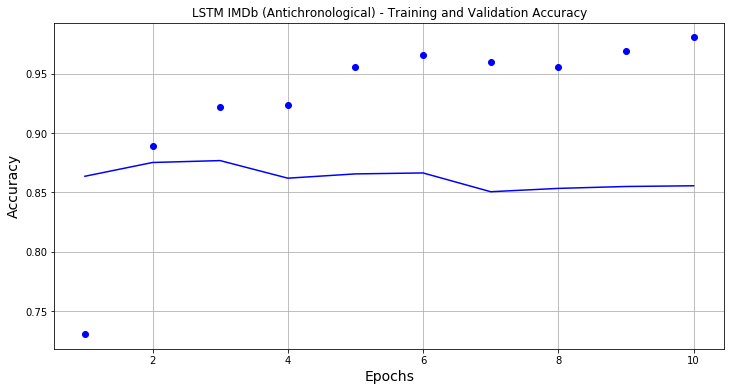

In [95]:
plot_history(history, plot_metrics=True, title_str='LSTM IMDb (Antichronological)')

### Bidirectional LSTM - `IMDb`

We've just established the following
- LSTM model trained on antichronological data performs almost as well as one trained on chronological data.
- Order of words in a sequence in NLP matters, but a **specific** order does not.
- Models trained on chronological and antichronologial sequences of data will extract different meaningful representations of the same data - these representations complement each other.
- Bidirectional LSTMs capture different aspects of the data: combine chronological with antichronological sequences. 
- Bidirectional models in `keras` take an RNN layer as an input and make two versions of it
  - one that processes data in forward sequence
  - one that processes data in reverse sequence

In [0]:
# Instantiate
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [0]:
# Train - on the JENA Climate data, not IMDB -> use generators
history = model.fit_generator(train_gen, 
                              steps_per_epoch=100,
                              epochs=20, 
                              validation_data=val_gen,
                              validation_steps=val_steps // 5)

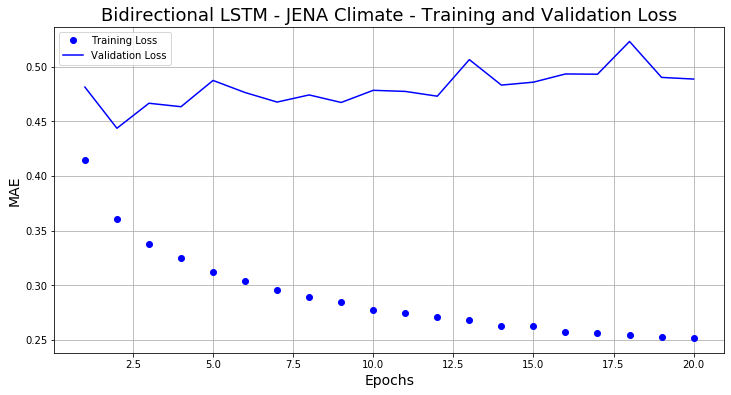

In [108]:
plot_history(history, plot_metrics=False, title_str='Bidirectional LSTM - JENA Climate')

# 1-D CNNs

- 1D CNNs operate in much the same way as their 2D counterparts for image processing.
- 1D CNNs extract windows of specific timesteps, convolve these windows with a weight matrix to transform these extracted patches, then downsample these patches using a pooling operation to reduce length of 1D inputs.
- 1D CNNs therefore learn patterns from patches that are translation invariant: a pattern learned at the beginning of a sequence during training will still be identified during testing even if it occurs at the end of the sequence. 
- However, this translation invariance makes CNNs insensitive to the order of timesteps: they will look for patterns anywhere within the sequence, and won't give preference to patterns occurring at earlier or later timesteps (which may be required for certain problems e.g. temperature forecasting).


In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [0]:
model = Sequential()

model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))

model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))

model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(1))

In [0]:
model.compile(optimizer=RMSprop(), loss='mae')

In [100]:
history = model.fit_generator(train_gen, steps_per_epoch=500, 
                              epochs=20, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 49s 98ms/step - loss: 0.4148 - val_loss: 0.4814
Epoch 2/20
500/500 [==============================] - 46s 91ms/step - loss: 0.3606 - val_loss: 0.4436
Epoch 3/20
500/500 [==============================] - 46s 92ms/step - loss: 0.3379 - val_loss: 0.4665
Epoch 4/20
500/500 [==============================] - 46s 91ms/step - loss: 0.3252 - val_loss: 0.4634
Epoch 5/20
500/500 [==============================] - 46s 92ms/step - loss: 0.3119 - val_loss: 0.4874
Epoch 6/20
500/500 [==============================] - 46s 92ms/step - loss: 0.3037 - val_loss: 0.4764
Epoch 7/20
500/500 [==============================] - 46s 92ms/step - loss: 0.2951 - val_loss: 0.4676
Epoch 8/20
500/500 [==============================] - 46s 92ms/step - loss: 0.2892 - val_loss: 0.4742
Epoch 9/20
500/500 [==============================] - 46s 92ms/step - loss: 0.2846 - val_loss: 0.4673
Epoch 10/20
500/500 [==============================] - 46s 92ms/step - loss: 0.277

# Combining CNNs with RNNs

1D CNNs are much faster than RNNs at extracting features from sequence data, but aren't very good making predictions based on the temporal position of these features within the sequence. 

RNNs are very good at using the temporal position of features (where the features occur in a sequence - towards the beginning, end, or in the middle) - but are very slow at processing large sequences, and also suffer from information loss over several timesteps. 

The solution here is to use a 1D CNN as a preprocessing step to extract higher-level, more abstract features and turn the long input sequence into much shorter (downsampled) sequences. 

This downsampled sequence of higher-level features then becomes the input to the RNN.

## Redefining Generators

In [0]:
# CNNs allow us to look at longer sequences or sequences with more data points
# So using a higher resolution - now data is sampled twice every hour instead of once
step = 3 

# Lookback is same - we are still using 5 days of data to make predictions
lookback = 720

# Delay is same - we are still going to predict the temperature 24 hours from now
delay = 144

In [0]:
train_gen = generator(float_data, 
                      lookback=lookback, 
                      delay=delay, 
                      min_index=0, 
                      max_index=200000, 
                      shuffle=True, 
                      step=step)

In [0]:
val_gen = generator(float_data,
                    lookback=lookback, 
                    delay=delay, 
                    min_index=200001, 
                    max_index=300000,
                    step=step)

In [0]:
test_gen = generator(float_data, 
                     lookback=lookback, 
                     delay=delay, 
                     min_index=300001, 
                     max_index=None, 
                     step=step)

In [0]:
val_steps = (300000 - 200001 - lookback) // 128 
test_steps = (len(float_data) - 300001 - lookback) // 128

## Building Model: 1D CNN Base + GRU Layer

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [0]:
model = Sequential()

model.add(layers.Conv1D(32, 5, activation='relu', 
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))

model.add(layers.Conv1D(32, 5, activation='relu'))

model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))

model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

In [113]:
history = model.fit_generator(train_gen, 
                              steps_per_epoch=500, 
                              epochs=20, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 89s 177ms/step - loss: 0.3428 - val_loss: 0.3011
Epoch 2/20
500/500 [==============================] - 85s 169ms/step - loss: 0.3113 - val_loss: 0.2872
Epoch 3/20
500/500 [==============================] - 84s 169ms/step - loss: 0.2972 - val_loss: 0.2801
Epoch 4/20
500/500 [==============================] - 83s 166ms/step - loss: 0.2895 - val_loss: 0.2854
Epoch 5/20
500/500 [==============================] - 84s 167ms/step - loss: 0.2816 - val_loss: 0.2915
Epoch 6/20
500/500 [==============================] - 83s 167ms/step - loss: 0.2748 - val_loss: 0.2848
Epoch 7/20
500/500 [==============================] - 82s 165ms/step - loss: 0.2684 - val_loss: 0.2838
Epoch 8/20
500/500 [==============================] - 82s 163ms/step - loss: 0.2653 - val_loss: 0.2944
Epoch 9/20
500/500 [==============================] - 82s 163ms/step - loss: 0.2597 - val_loss: 0.2985
Epoch 10/20
500/500 [==============================] - 82s 165ms/step - l

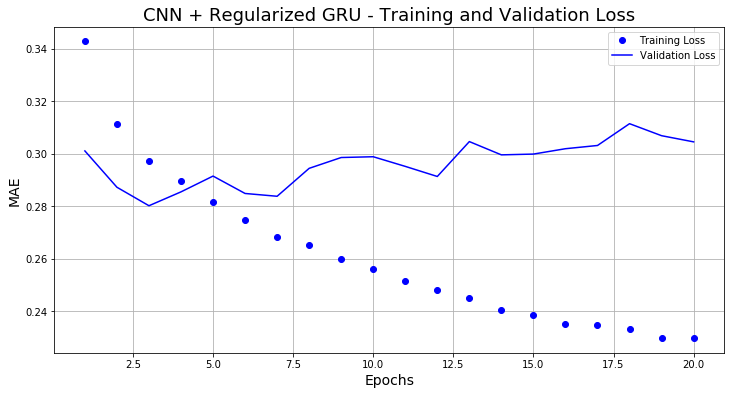

In [114]:
plot_history(history, plot_metrics=False, title_str='CNN + Regularized GRU')

Not much improvement in temperature prediction over the original GRU model, but must take into account that it offers comparable performance with much lower training time.

This is the advantage of using 1D CNNs with RNNs: by downsampling input sequences and extracting high-level features, they can speed up predictions with recurrent networks.